## Segment a sparse 3D image with a single material component  

The goal of this notebook is to develop a 3D segmentation algorithm that improves segmentation where features are detected.

**Data:** AM parts from Xuan Zhang. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
import time
import seaborn as sns
import pandas as pd

import cupy as cp
from tomo_encoders import Patches
from tomo_encoders.misc import viewer
from tomo_encoders import DataFile
from tomo_encoders.reconstruction.recon import recon_binning, recon_patches_3d, rec_patch, rec_pts, rec_pts_xy
# from tomo_encoders.misc.voxel_processing import cylindrical_mask, normalize_volume_gpu

In [2]:
r_fac = 0.2
ht = 32
wd = 2176
th = 1500
n_sel = int(ht*wd*wd*r_fac/(32**3))

In [3]:
# arguments to recon_chunk2: data, theta, center, p3d
data = cp.random.normal(0,1,(th, ht, wd), dtype = cp.float32)
theta = cp.linspace(0, np.pi, th, dtype = cp.float32)
center = wd/2
p_sel = Patches((ht,wd,wd), initialize_by = 'regular-grid', patch_size = (32,32,32), n_points = n_sel)
print(f'r = N(P)/N(V): {len(p_sel)*32**3/(ht*wd*wd):.2f}')

r = N(P)/N(V): 0.20


In [4]:
times = []
for i in range(5):
    obj_patch, t_ = rec_patch(data, theta, center, 0, wd, 0, wd, 0, ht, TIMEIT=True)
    print(f"time {t_:.2f} ms")
    times.append(t_)
print(f"time = {np.median(times):.2f} ms")    

time 1355.99 ms
time 1306.63 ms
time 1309.68 ms
time 1308.86 ms
time 1317.93 ms
time = 1309.68 ms


## rec_pts: 15 pc slower  
output to obj2  

In [5]:
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    vol = cp.zeros((ht,wd,wd), dtype = cp.uint8)
    x = cp.ones((len(p_sel), 32, 32, 32), dtype = cp.uint8)
    
    for idx in range(len(p_sel)):
        
        s = (slice(p_sel.points[idx,0], p_sel.points[idx,0] + 32), \
             slice(p_sel.points[idx,1], p_sel.points[idx,1] + 32), \
             slice(p_sel.points[idx,2], p_sel.points[idx,2] + 32))
        vol[s] = x[idx]
    vox_coords = cp.where(cp.array(vol) == 1) 
    pts = cp.asarray(cp.asarray(vox_coords), dtype = cp.int32).T # this is already sorted as contiguous array
    stream.synchronize()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for making points array: {t_meas:.2f} ms")

for i in range(5):
    f = rec_pts(data, theta, center, pts)
    
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    obj_pts = cp.ones((ht,wd,wd), dtype = f.dtype)
    obj_pts[vox_coords] = f
    sub_vols = p_sel.extract(obj_pts, (32,32,32))
    stream.synchronize()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for extracting sub_vols: {t_meas:.2f} ms")    

overhead for making points array: 34.22 ms
TIME rec_pts: 276.91 ms
TIME rec_pts: 278.09 ms
TIME rec_pts: 277.77 ms
TIME rec_pts: 280.47 ms
TIME rec_pts: 277.84 ms
overhead for extracting sub_vols: 18.65 ms


## rec_pts_xy: 20 pc slower  
output to obj3

In [6]:
pts_32 = np.asarray([p_sel.points[ii,1:] for ii in range(len(p_sel))])
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    img = cp.zeros((wd,wd), dtype = cp.uint8)
    x = cp.ones((len(p_sel), 32, 32), dtype = cp.uint8)
    
    for idx in range(len(p_sel)):
        
        s = (slice(pts_32[idx,0], pts_32[idx,0] + 32), slice(pts_32[idx,1], pts_32[idx,1] + 32))
        img[s] = x[idx]
        
    pix_coords = cp.where(cp.array(img) == 1) 
    pts_xy = cp.asarray(cp.asarray(pix_coords), dtype = cp.int32).T # this is already sorted as contiguous array
    stream.synchronize()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for making points array: {t_meas:.2f} ms")
for i in range(5):
    f = rec_pts_xy(data, theta, center, pts_xy)
    
start_gpu = cp.cuda.Event(); end_gpu = cp.cuda.Event(); start_gpu.record()
stream = cp.cuda.Stream()
with stream:
    obj_pts_xy = cp.ones((ht,wd,wd), dtype = f.dtype)#*f.min()
    for ii in range(ht):
        obj_pts_xy[ii, pix_coords[0], pix_coords[1]] = f[ii*len(pts_xy):(ii+1)*len(pts_xy)]
    sub_vols = p_sel.extract(obj_pts_xy, (32,32,32))
    stream.synchronize()
end_gpu.record(); end_gpu.synchronize(); t_meas = cp.cuda.get_elapsed_time(start_gpu,end_gpu)
print(f"overhead for extracting sub_vols: {t_meas:.2f} ms")        

overhead for making points array: 17.01 ms
TIME rec_pts: 287.44 ms
TIME rec_pts: 290.59 ms
TIME rec_pts: 288.35 ms
TIME rec_pts: 290.43 ms
TIME rec_pts: 288.65 ms
overhead for extracting sub_vols: 11.58 ms


Does the reconstruction of points reconcile with the full volume? True
Does the reconstruction of points reconcile with the full volume? True


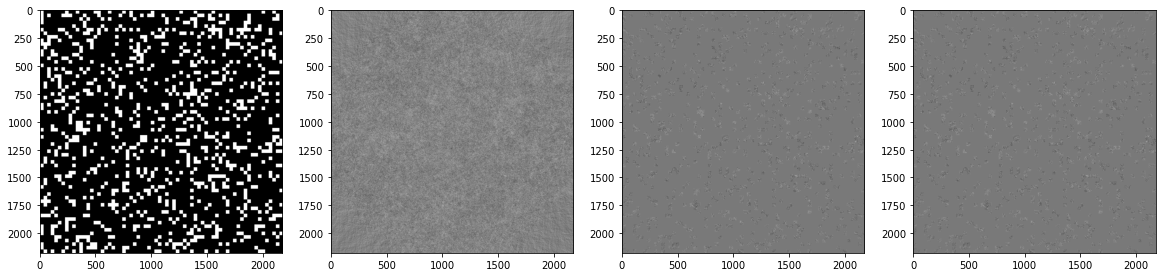

In [7]:
idp = ht//2
print(f'Does the reconstruction of points reconcile with the full volume? {~np.any(obj_pts[vox_coords]-obj_patch[vox_coords])}')
print(f'Does the reconstruction of points reconcile with the full volume? {~np.any(obj_pts_xy[vox_coords]-obj_patch[vox_coords])}')
fig, ax = plt.subplots(1,4, figsize = (20,5))
ax[0].imshow(vol[idp].get(), cmap = 'gray')
ax[1].imshow(obj_patch.get()[idp], cmap = 'gray')
ax[2].imshow(obj_pts.get()[idp], cmap = 'gray')
ax[3].imshow(obj_pts_xy.get()[idp], cmap = 'gray')